## Autoregressive Model 


An autoregressive model is when a value from a time series is regressed on previous values from that same time series. for example, $y_t$ on $y_{t-1}$

$y_t$ = $\beta_0 + \beta_1y_{t-1} + \epsilon_t$

$y_{t-1}$ - previous value

$\beta_0$ - constant (bias)

$\beta_1$ - coeff 

$\epsilon_t$ - Residual (error term)

!! How many lags we need to keep !! - Depending on our task. More lags make models more complex.

Note: we use Auto-correlation, and Partial Autocorrelation to determine the number of lags.

#### Determining the number of Lags using ACF and PACF


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

##### Primary preprocessing 

In [35]:
raw_csv_data = pd.read_csv("./../datasets/Index2018.csv") 
df=raw_csv_data.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index("date", inplace=True)
df=df.asfreq('b')
df=df.fillna(method='ffill')

In [36]:
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [37]:
# picking market value for FTSE 
df['market_value'] = df.ftse

df.drop(["spx","ftse", "nikkei","dax"], axis=1, inplace=True)
df.describe()

,market_value
count,6277.000000
mean,5423.679824
std,1145.616719
min,2876.600000
25%,4486.730000
50%,5663.300000
75%,6304.630175
max,7778.637689


#### Split the data

In [38]:
train_locs = int(df.shape[0]*0.8)
train_locs

5021

In [39]:
df_train, df_test = df.iloc[:train_locs], df.iloc[train_locs:]
df_train, df_test

(            market_value
 date                    
 1994-01-07       3445.98
 1994-01-10       3440.58
 1994-01-11       3413.77
 1994-01-12       3372.02
 1994-01-13       3360.01
 ...                  ...
 2013-04-01       6411.74
 2013-04-02       6490.66
 2013-04-03       6420.28
 2013-04-04       6344.11
 2013-04-05       6249.77
 
 [5021 rows x 1 columns],
             market_value
 date                    
 2013-04-08   6276.940000
 2013-04-09   6313.200000
 2013-04-10   6387.370000
 2013-04-11   6416.140000
 2013-04-12   6384.390000
 ...                  ...
 2018-01-23   7731.827774
 2018-01-24   7643.428966
 2018-01-25   7615.839954
 2018-01-26   7665.541292
 2018-01-29   7671.533300
 
 [1256 rows x 1 columns])

#### ACF

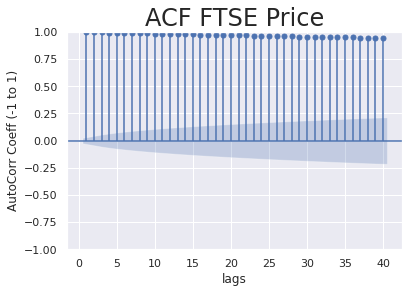

In [40]:
sgt.plot_acf(df.market_value, lags=40, zero=False) 
plt.title("ACF FTSE Price", size=24)
plt.ylabel("AutoCorr Coeff (-1 to 1)")
plt.xlabel("lags")
plt.show()

#### PACF

/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


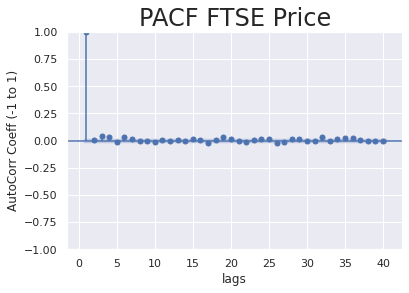

In [41]:
sgt.plot_pacf(df.market_value, lags=40, zero=False) 
plt.title("PACF FTSE Price", size=24)
plt.ylabel("AutoCorr Coeff (-1 to 1)")
plt.xlabel("lags")
plt.show()

Looking at the both graph, we have coefficients that are not significant. The ACF all 40 lag values have ACF coefficient between 0.9 -1, but the PACF coefficients are different. There are some negatively correlated values too. In PACF graph, lags later than 20 are insignificant. Hence, we can conclude 20 lags for our AR model. 

#### AR (1) Model 

Autoregressive model with 1 lag.

In [47]:
ar_model = ARIMA(df.market_value, order=(1,0,1))

In [48]:
ar_results = ar_model.fit()

In [49]:
ar_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6277
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -34437.824
Date:                Mon, 15 Aug 2022   AIC                          68883.648
Time:                        19:10:30   BIC                          68910.626
Sample:                    01-07-1994   HQIC                         68892.995
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5423.6798    477.815     11.351      0.000    4487.180    6360.180
ar.L1          0.9988      0.001   1423.872      0.000       0.997       1.000
ma.L1         -0.0091      0.009     -1.043      0.297      -0.026       0.008
sigma2      3408.1272     36.326     93.822      0.000    3336.931    3479.324
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3642.53
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.20
Prob(H) (two-sided):                  0.24   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Lets put the summary into AR equation
$y_t$ = $\beta_0 + \beta_1y_{t-1} + \epsilon_t$

looking at the ARIMA Model summary. 

$\beta_0$ = 5423.6789

$\beta_2$ = 0.9988 (Can match with ACF graph too)

$\epsilon_t$ = 0.001

$Z$ - z statistics 

$P>|z|$ - p-value, we have 0.00, and safe to conclude the \beta_0$ and $\beta_1y_{t-1}$ are significantly different than zero.

[0.025  0.975] - Gives us the 90% confidence interval. Since, zero is not part if it, hence we can conclude that the coefficients are significant. 